<a href="https://colab.research.google.com/github/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/blob/main/circannual_birth_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main graph - figure 1

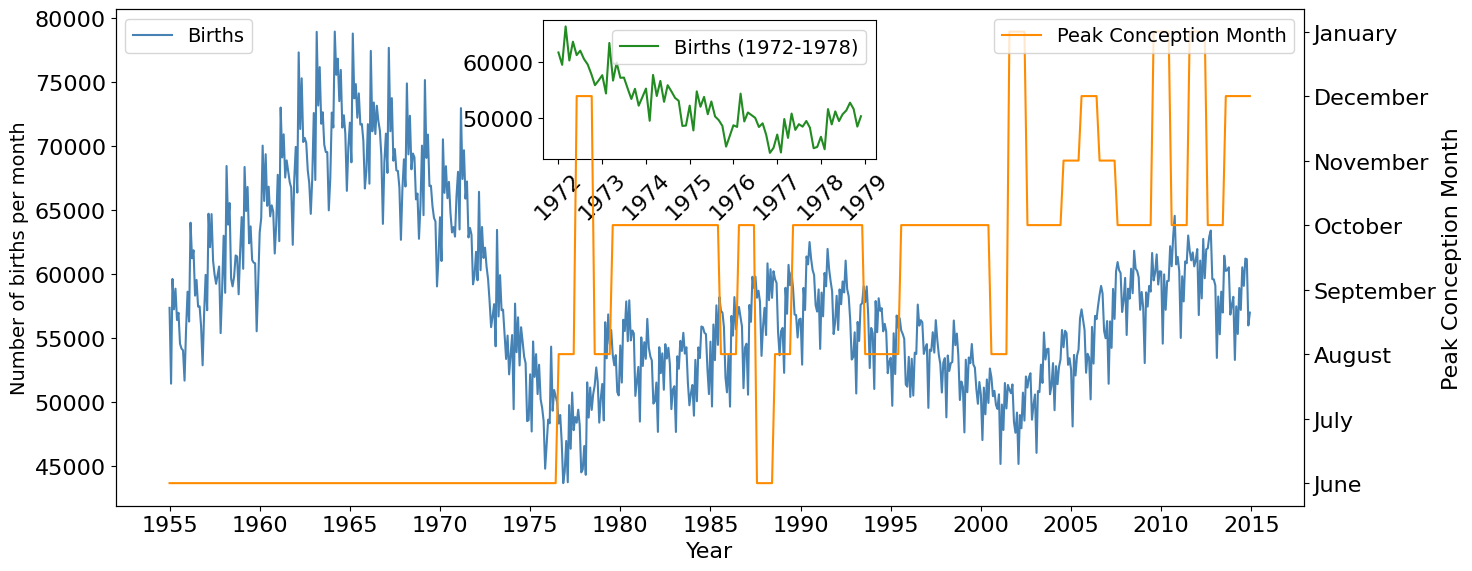

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 16})  # Change '16' to your preferred font size.

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Create a new figure with a specific size (width, height)
fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'steelblue'
ax1.set_xlabel('Year', color='black')
ax1.set_ylabel('Number of births per month', color='black', fontsize=14)
ax1.plot(data['Date'], data['Births'], color=color, label='Births')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(False)  # Remove gridlines

ax2 = ax1.twinx()
color = 'darkorange'

# Setting the labels for y-axis
months = ['June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May']
ax2.set_yticks(range(6, 14))
ax2.set_yticklabels(months[0:8])

ax2.set_ylabel('Peak Conception Month', color='black')
ax2.plot(data['Date'], data['PeakConceptionMonth'], color=color, label='Peak Conception Month')
ax2.tick_params(axis='y', labelcolor='black')
ax2.grid(False)  # Remove gridlines

# Automatically adjust subplot parameters to give specified padding
fig.tight_layout()

# plt.title('Births and Peak Conception Month Over the Years', fontsize=20, color='black')

# Create a set of inset Axes: these should fill the bounding box allocated to them
ax3 = inset_axes(ax2, width="28%", height="28%", loc=9)  # loc=9 for center top
ax3.plot(data.loc[(data['Year'] >= 1972) & (data['Year'] <= 1978), 'Date'],
         data.loc[(data['Year'] >= 1972) & (data['Year'] <= 1978), 'Births'], color='forestgreen', label='Births (1972-1978)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(False)  # Remove gridlines

# Move ax2 to the top layer
ax2.set_zorder(ax1.get_zorder() + 1)
ax2.patch.set_visible(False)

# Add legends
ax1.legend(loc='upper left', fontsize=14)
ax2.legend(loc='upper right', fontsize=14)
ax3.legend(loc='upper right', fontsize=14)

# Adjust x-axis to go up in 5-year increments
years = mdates.YearLocator(5)
years_fmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)

# Save the plot with 300 DPI
plt.savefig('births_and_peak_conception.png', dpi=300)

# Show the plot
plt.show()


Figure 2

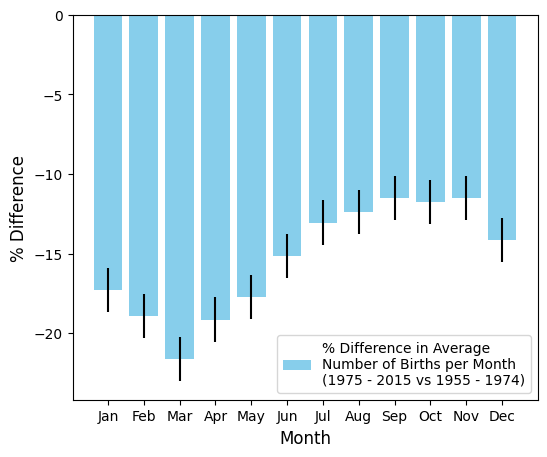

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Create a new column 'MonthNum' to represent month in numerical format
data['MonthNum'] = data['Date'].dt.month

# Separate data into two periods
data_1955_1974 = data[(data['Year'] >= 1955) & (data['Year'] <= 1974)]
data_1975_2015 = data[(data['Year'] >= 1975) & (data['Year'] <= 2015)]

# Calculate mean and standard error for both periods
grouped_1955_1974 = data_1955_1974.groupby('MonthNum')['Births'].agg(['mean', 'sem'])
grouped_1975_2015 = data_1975_2015.groupby('MonthNum')['Births'].agg(['mean', 'sem'])

# Create plot
fig, ax = plt.subplots(figsize=(6, 5))

months = list(range(1, 13))

# Plot percentage difference in average values for each month
percentage_difference = ((grouped_1975_2015['mean'] - grouped_1955_1974['mean']) / grouped_1955_1974['mean']) * 100

# Number of bootstrap samples
n_bootstrap_samples = 1000

# Initialize an array to hold the bootstrap samples
bootstrap_samples = np.zeros(n_bootstrap_samples)

# Perform the bootstrap sampling and calculate percentage difference
for i in range(n_bootstrap_samples):
    # Sample with replacement from each condition
    bootstrap_sample_1955_1974 = np.random.choice(grouped_1955_1974['mean'], size=len(grouped_1955_1974['mean']), replace=True)
    bootstrap_sample_1975_2015 = np.random.choice(grouped_1975_2015['mean'], size=len(grouped_1975_2015['mean']), replace=True)

    # Calculate the percentage difference for this bootstrap sample
    bootstrap_samples[i] = (np.mean(bootstrap_sample_1975_2015) - np.mean(bootstrap_sample_1955_1974)) / np.mean(bootstrap_sample_1955_1974) * 100

# Calculate the standard error of the percentage difference
sem_bootstrap = np.std(bootstrap_samples)

# Plot the percentage difference with error bars
ax.bar(months, percentage_difference, yerr=sem_bootstrap, color='skyblue')
ax.legend(['% Difference in Average\nNumber of Births per Month\n(1975 - 2015 vs 1955 - 1974)'], loc='lower right')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('% Difference', fontsize=12)
ax.set_xticks(months)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.savefig('percentage_difference_bpm.png', dpi=300)
plt.show()


Seasonal Decomposition

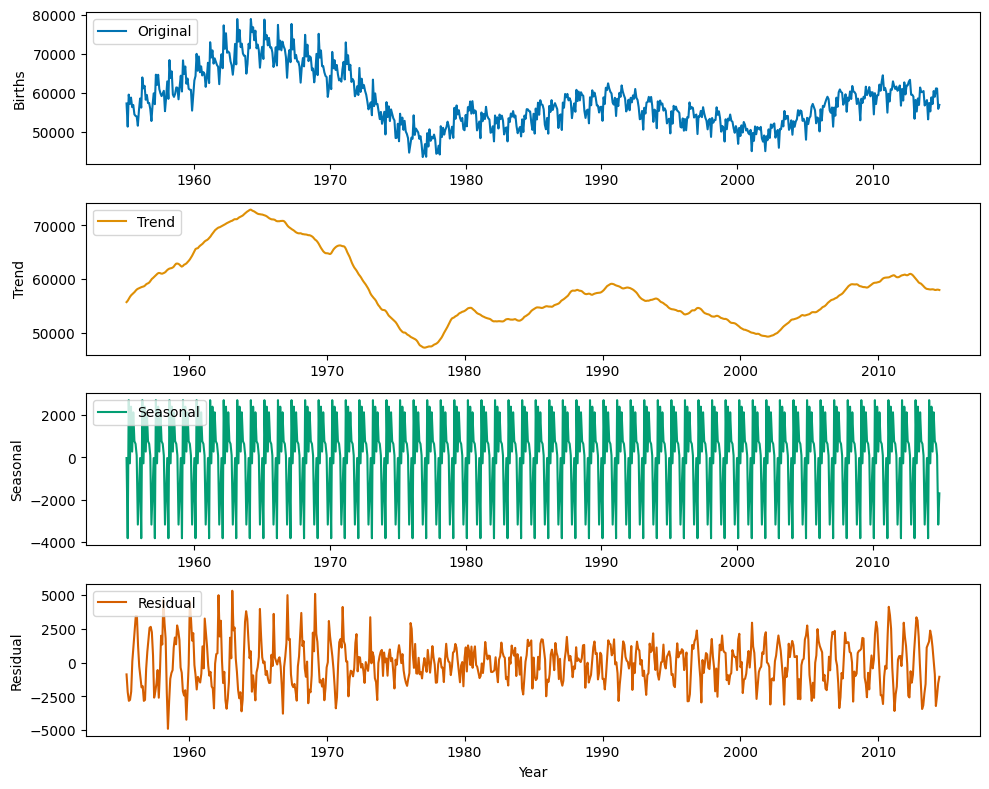

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Set 'Date' column as the index
data.set_index('Date', inplace=True)

# Apply seasonal decomposition
decomposition = seasonal_decompose(data['Births'], model='additive', period=12)

# Retrieve the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Set color palette
palette = sns.color_palette('colorblind')

# Plot the original data, trend, seasonal, and residual components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(data['Births'], label='Original', color=palette[0])
plt.legend(loc='upper left')
plt.ylabel('Births')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color=palette[1])
plt.legend(loc='upper left')
plt.ylabel('Trend')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color=palette[2])
plt.legend(loc='upper left')
plt.ylabel('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color=palette[3])
plt.legend(loc='upper left')
plt.ylabel('Residual')

plt.xlabel('Year')
plt.tight_layout()
plt.show()


Peak time analysis

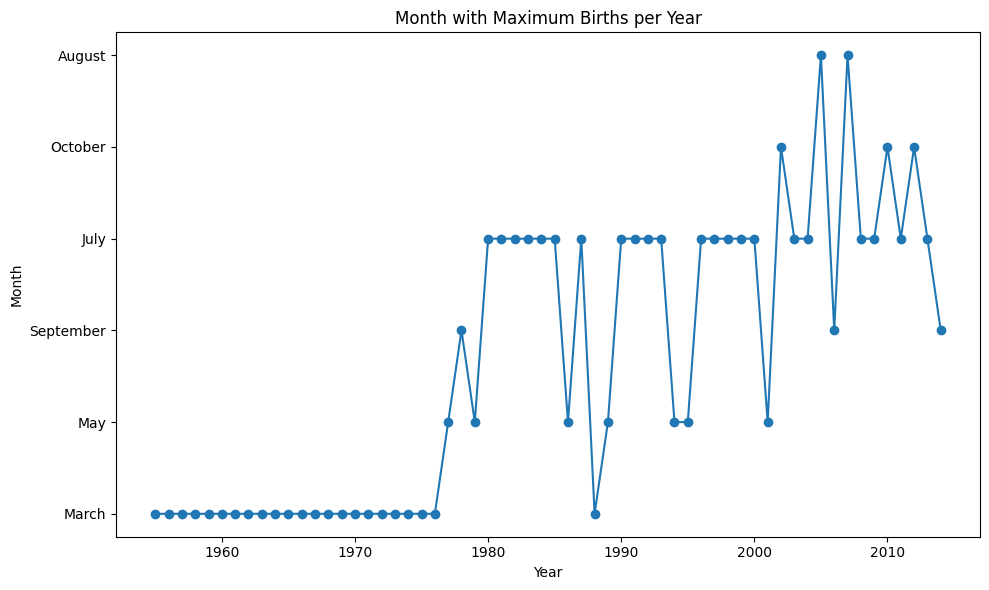

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Group data by year and find the month with the maximum number of births
max_month_per_year = data.groupby('Year')['Births'].idxmax()
month_max_births = data.loc[max_month_per_year]['Month']

# Plot the month with the maximum number of births per year
plt.figure(figsize=(10, 6))
plt.plot(data['Year'].unique(), month_max_births, marker='o')
plt.xlabel('Year')
plt.ylabel('Month')
plt.title('Month with Maximum Births per Year')

plt.tight_layout()
plt.show()

Sine curve model fitting

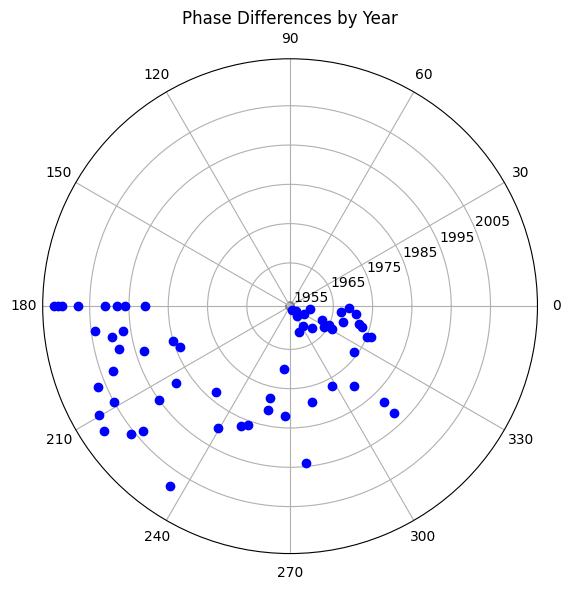

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Group data by year and fit sine curve for each year
years = data['Year'].unique()

phase_differences = []
for year in years:
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['Births']

    # Define the sinusoidal model function
    def sinusoidal_model(x, amplitude, period, phase, offset):
        return amplitude * np.sin(2 * np.pi * x / period + phase) + offset

    # Set initial parameter values
    initial_params = [np.max(y) - np.min(y), 12, 0, np.min(y)]

    # Fit the data with the sinusoidal model using curve_fit
    popt, pcov = curve_fit(sinusoidal_model, x, y, p0=initial_params, bounds=([0, 9, -np.pi, -np.inf], [np.inf, 15, np.pi, np.inf]), maxfev=100000)
    phase_difference = popt[2]  # Get phase difference in radians

    phase_differences.append(phase_difference)

# Plot the phase differences on modified polar plot
plt.figure(figsize=(6, 6))
plt.polar(np.linspace(0, 2 * np.pi, len(phase_differences) + 1)[:-1], np.ones_like(phase_differences), color='gray', linestyle='--')
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo')
plt.thetagrids(range(0, 360, 30), labels=['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330'])
plt.rgrids(np.arange(1, len(phase_differences) + 1, 10), labels=[str(year) for year in years if year % 10 == 5])
plt.title('Phase Differences by Year')
plt.tight_layout()
plt.show()

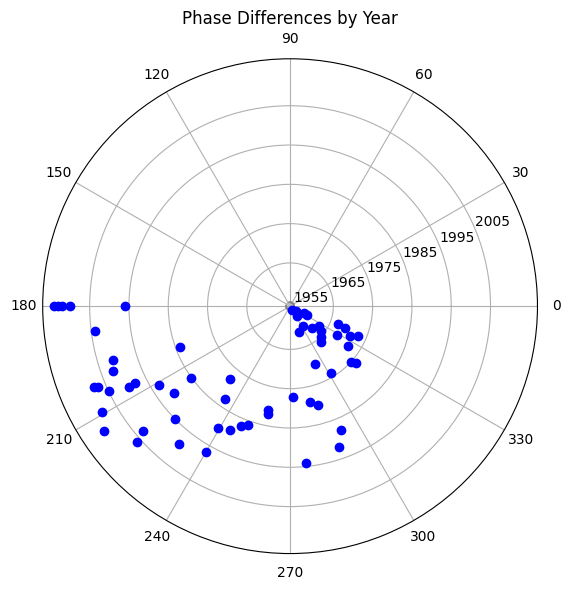

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Group data by year and fit sine curve for each year
years = data['Year'].unique()

phase_differences = []
for year in years:
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['Births']

    # Define the sinusoidal model function
    def sinusoidal_model(x, amplitude, period, phase, offset):
        return amplitude * np.sin(2 * np.pi * x / period + phase) + offset

    # Set initial parameter values
    initial_params = [np.max(y) - np.min(y), 12, 0, np.min(y)]

    # Fit the data with the sinusoidal model using curve_fit
    popt, pcov = curve_fit(sinusoidal_model, x, y, p0=initial_params, bounds=([0, 11, -np.pi, -np.inf], [np.inf, 13, np.pi, np.inf]), maxfev=100000)
    phase_difference = popt[2]  # Get phase difference in radians

    phase_differences.append(phase_difference)

# Plot the phase differences on modified polar plot
plt.figure(figsize=(6, 6))
plt.polar(np.linspace(0, 2 * np.pi, len(phase_differences) + 1)[:-1], np.ones_like(phase_differences), color='gray', linestyle='--')
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo')
plt.thetagrids(range(0, 360, 30), labels=['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330'])
plt.rgrids(np.arange(1, len(phase_differences) + 1, 10), labels=[str(year) for year in years if year % 10 == 5])
plt.title('Phase Differences by Year')
plt.tight_layout()
plt.show()

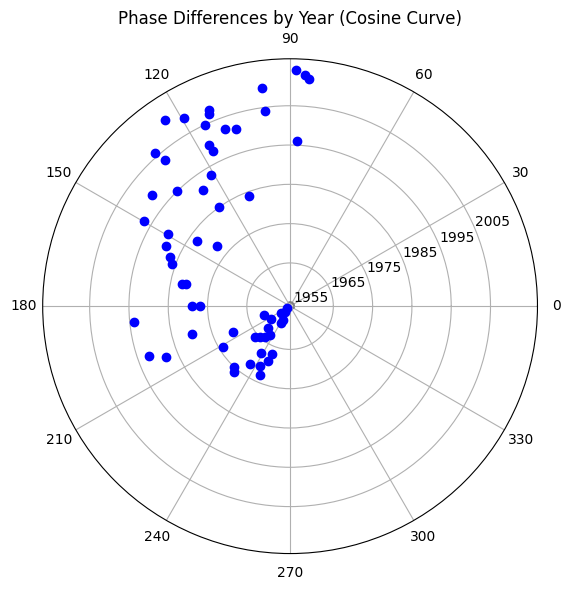

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Group data by year and fit cosine curve for each year
years = data['Year'].unique()

phase_differences = []
for year in years:
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['Births']

    # Define the cosine model function
    def cosine_model(x, amplitude, period, phase, offset):
        return amplitude * np.cos(2 * np.pi * x / period + phase) + offset

    # Set initial parameter values
    initial_params = [np.max(y) - np.min(y), 12, 0, np.min(y)]

    # Fit the data with the cosine model using curve_fit
    popt, pcov = curve_fit(cosine_model, x, y, p0=initial_params, bounds=([0, 11, -np.pi, -np.inf], [np.inf, 13, np.pi, np.inf]), maxfev=100000)
    phase_difference = popt[2]  # Get phase difference in radians

    phase_differences.append(phase_difference)

# Plot the phase differences on modified polar plot
plt.figure(figsize=(6, 6))
plt.polar(np.linspace(0, 2 * np.pi, len(phase_differences) + 1)[:-1], np.ones_like(phase_differences), color='gray', linestyle='--')
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo')
plt.thetagrids(range(0, 360, 30), labels=['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330'])
plt.rgrids(np.arange(1, len(phase_differences) + 1, 10), labels=[str(year) for year in years if year % 10 == 5])
plt.title('Phase Differences by Year (Cosine Curve)')
plt.tight_layout()
plt.show()

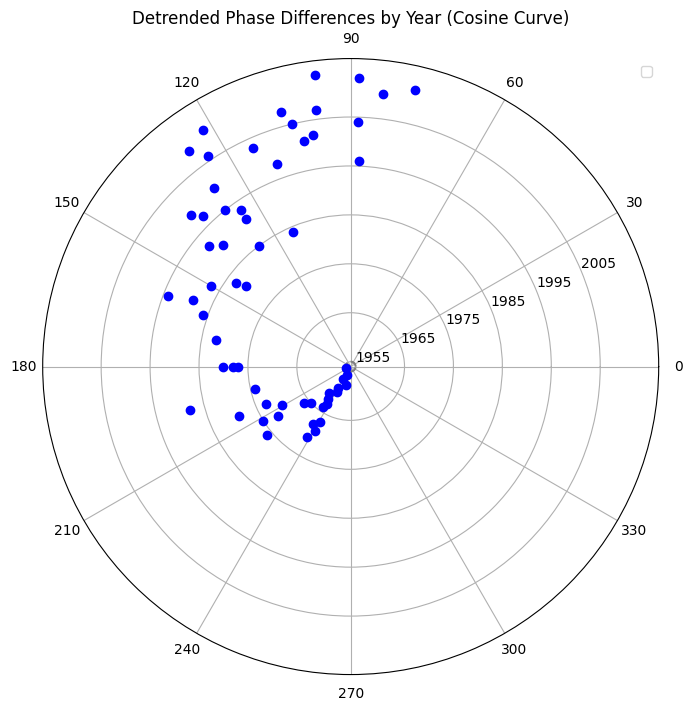

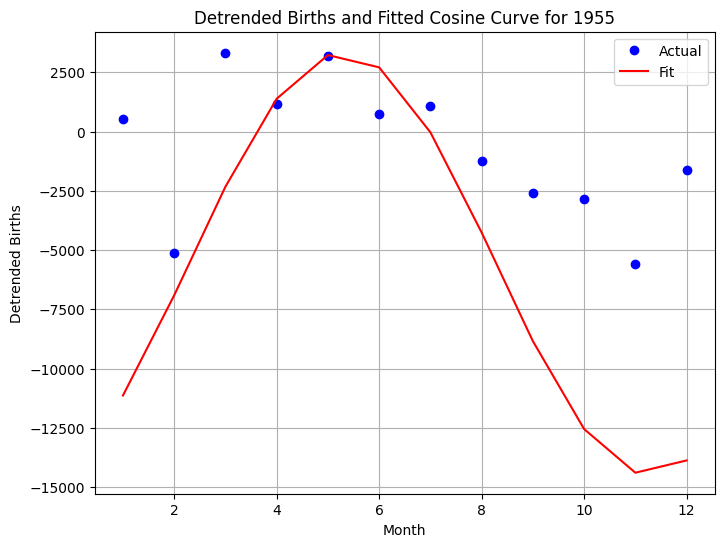

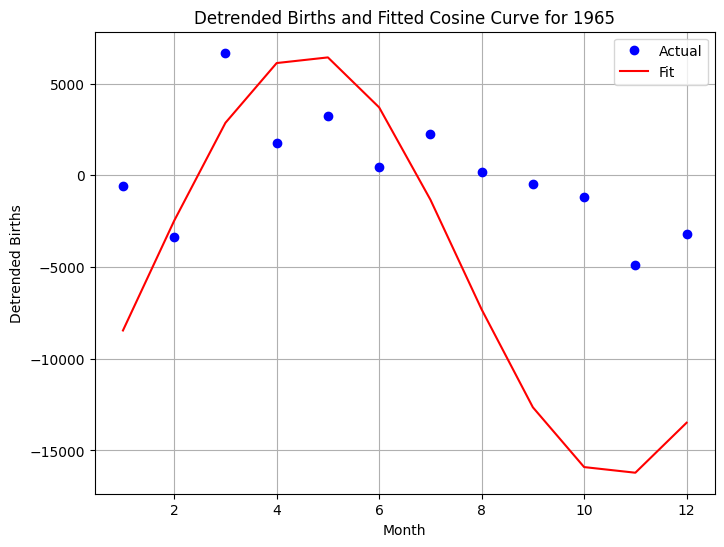

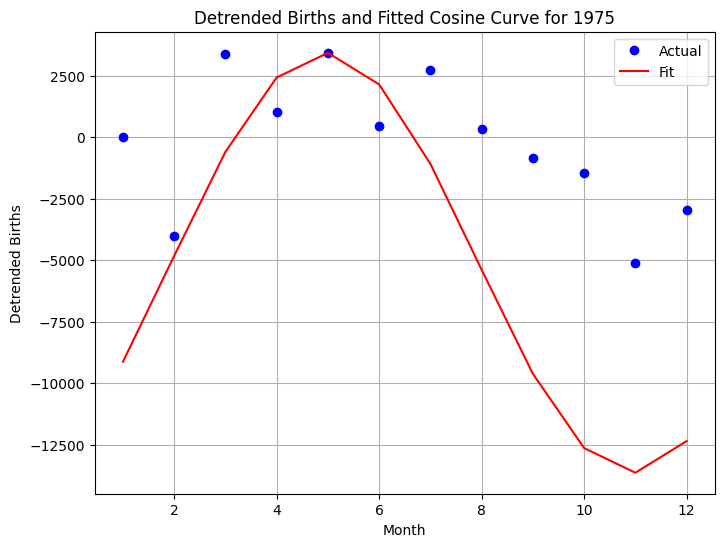

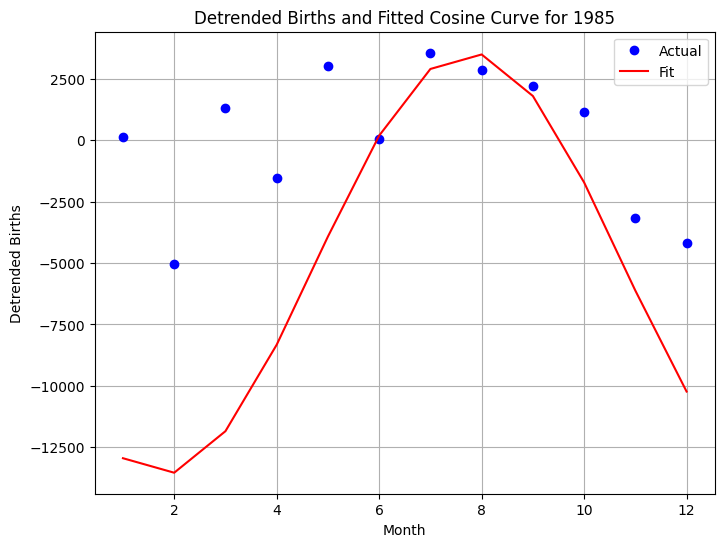

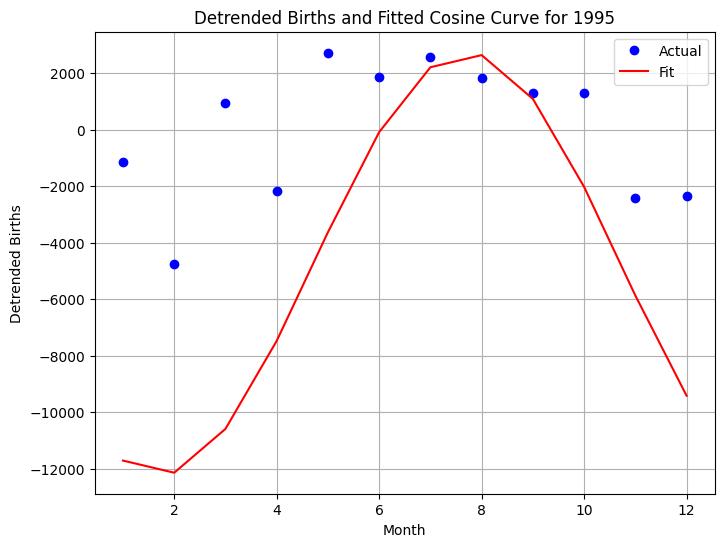

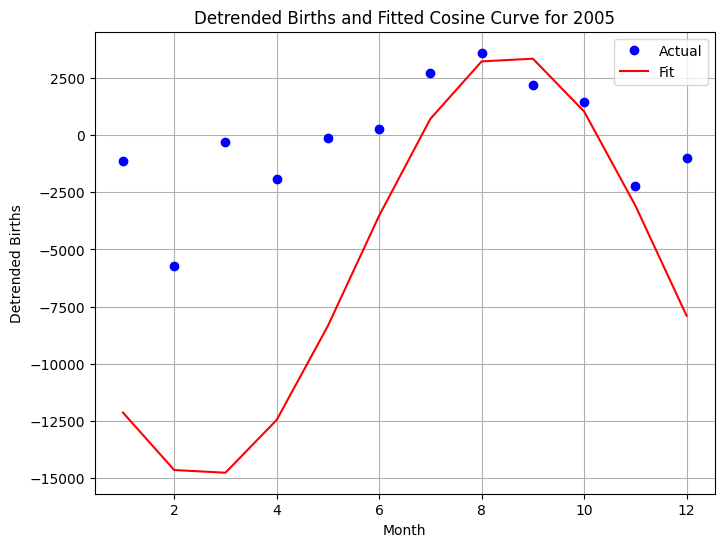

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm


# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Detrend the data using a 13-month sliding average for data_1976_2014
x = np.arange(len(data))
y = data['Births'].values

# Calculate the 13-month rolling average
y_detrend = pd.Series(y).rolling(window=13, center=True, min_periods=1).mean().values

# Subtract detrended values from original data and store in a new column
data['DetrendedBirths'] = y - y_detrend

# Group data by year and fit cosine curve for each year
years = data['Year'].unique()

phase_differences = []
for year in years:
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['DetrendedBirths']

    # Define the cosine model function
    def cosine_model(x, amplitude, period, phase, offset):
        return amplitude * np.cos(2 * np.pi * x / period + phase) + offset

    # Set initial parameter values
    initial_params = [np.max(y) - np.min(y), 12, 0, np.min(y)]

    # Fit the data with the cosine model using curve_fit
    popt, pcov = curve_fit(cosine_model, x, y, p0=initial_params, bounds=([0, 11, -np.pi, -np.inf], [np.inf, 13, np.pi, np.inf]), maxfev=100000)
    phase_difference = popt[2]  # Get phase difference in radians

    phase_differences.append(phase_difference)


# Plot the phase differences
plt.figure(figsize=(8, 8))
plt.polar(np.linspace(0, 2 * np.pi, len(phase_differences) + 1)[:-1], np.ones_like(phase_differences), color='gray', linestyle='--')
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo')
plt.thetagrids(range(0, 360, 30), labels=['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330'])
plt.rgrids(np.arange(1, len(phase_differences) + 1, 10), labels=[str(year) for year in years if year % 10 == 5])

plt.legend()
plt.title('Detrended Phase Differences by Year (Cosine Curve)')
plt.show()

# Define the cosine model function for convenience
def cosine_model(x, amplitude, period, phase, offset):
    return amplitude * np.cos(2 * np.pi * x / period + phase) + offset

# List of years to generate plots for
plot_years = [1955, 1965, 1975, 1985, 1995, 2005]

for year in plot_years:
    # Get the data and phase difference for the selected year
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['DetrendedBirths']
    phase_difference = phase_differences[years.tolist().index(year)]

    # Use the phase difference to predict the detrended birth rates using the cosine model
    amplitude_estimate = np.max(y) - np.min(y)
    offset_estimate = np.min(y)
    y_fit = cosine_model(x, amplitude_estimate, 12, phase_difference, offset_estimate)

    # Plot the actual and predicted data
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'bo', label='Actual')
    plt.plot(x, y_fit, 'r-', label='Fit')
    plt.title(f'Detrended Births and Fitted Cosine Curve for {year}')
    plt.xlabel('Month')
    plt.ylabel('Detrended Births')
    plt.legend()
    plt.grid()
    plt.show()


FFT analysis

<ipython-input-13-8a9be547abfd>:29: RuntimeWarning: divide by zero encountered in true_divide
  periods_1955_1974 = 1 / frequencies_1955_1974
<ipython-input-13-8a9be547abfd>:30: RuntimeWarning: divide by zero encountered in true_divide
  periods_1976_2014 = 1 / frequencies_1976_2014


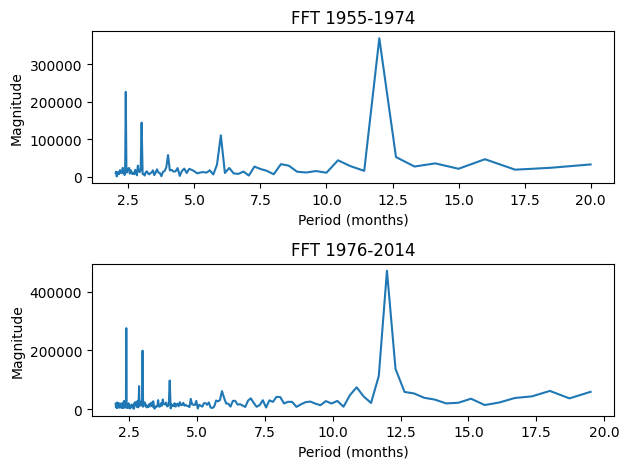

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Split data into two time periods
data_1955_1974 = data[(data['Year'] >= 1955) & (data['Year'] <= 1974)]
data_1976_2014 = data[(data['Year'] >= 1976) & (data['Year'] <= 2014)]

# Apply FFT to 'Births' column of the dataframes
fft_1955_1974 = np.fft.fft(data_1955_1974['Births'])
fft_1976_2014 = np.fft.fft(data_1976_2014['Births'])

# Calculate the frequencies and corresponding periods (in months)
N_1955_1974 = data_1955_1974.shape[0]
N_1976_2014 = data_1976_2014.shape[0]
frequencies_1955_1974 = np.fft.fftfreq(N_1955_1974)
frequencies_1976_2014 = np.fft.fftfreq(N_1976_2014)

# Convert frequencies to periods (in months)
periods_1955_1974 = 1 / frequencies_1955_1974
periods_1976_2014 = 1 / frequencies_1976_2014

# Filter only for period values between 1 to 20 months
indices_1955_1974 = (periods_1955_1974 >= 1) & (periods_1955_1974 <= 20)
indices_1976_2014 = (periods_1976_2014 >= 1) & (periods_1976_2014 <= 20)

# Plotting
fig, axs = plt.subplots(2)

# 1955-1974
axs[0].plot(periods_1955_1974[indices_1955_1974], np.abs(fft_1955_1974)[indices_1955_1974])
axs[0].set_title('FFT 1955-1974')
axs[0].set_xlabel('Period (months)')
axs[0].set_ylabel('Magnitude')

# 1976-2014
axs[1].plot(periods_1976_2014[indices_1976_2014], np.abs(fft_1976_2014)[indices_1976_2014])
axs[1].set_title('FFT 1976-2014')
axs[1].set_xlabel('Period (months)')
axs[1].set_ylabel('Magnitude')

plt.tight_layout()
plt.show()
